In [1]:
import sys

import pandas as pd
import torch

from hmlstm.utils import plot_z, get_boundaries, evaluate_z, get_z, stack_z

try:
    from google.colab import drive

    IN_COLAB = True

    drive.mount('/content/drive')
    path = "/content/drive/My Drive/Colab Notebooks/"

    # for python imports from google drive
    sys.path.append(path)
except:
    IN_COLAB = False
    path = "./"

from utils.datasets import Characters as TextDataset
from utils import HMLSTMTrainer as Trainer, print_cuda_info, load_model
from hmlstm import HMLSTMNetwork

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

if use_cuda:
    print_cuda_info()
    torch.cuda.empty_cache()
    # torch.set_num_threads(1)

device = torch.device('cuda' if use_cuda else 'cpu')

cuda device: 0 / name: GeForce GTX 1080 Ti / cuda-capability: (6, 1) / memory: 11.0 GB


In [3]:
seq_len = 60

project_name = "shakespeare"

path_data = path + "projects/" + project_name + "/data/"
path_states = path + "projects/" + project_name + "/states/"
dataset = TextDataset(path_data + "data.txt", seq_length=seq_len)

In [4]:
print(f"dataset length: {len(dataset)}")

i = 100
x, y, i = dataset.get_sample(i, decode=False)
print(f"sample: \"{dataset.decode(x)}\"")

dataset length: 87128
sample: "resistance.
PAROLLES
     There is none: man, sitting down b"


reference boundaries


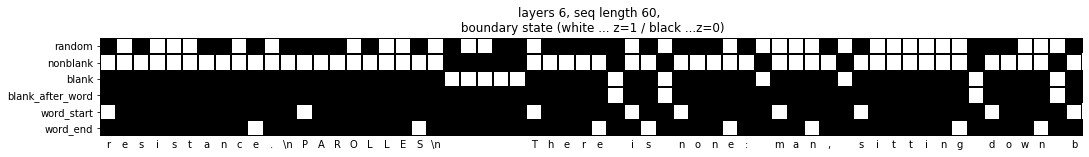

In [5]:
metrics = {
    "word_end": r"[a-zA-Z]\b",
    "word_start": r"\b[a-zA-Z]",
#    "blank_before_word": r" \b",
    "blank_after_word": r"\b ",
    "blank": r" ",
    "nonblank": r"[^ ]",
    "random": "random_0.5" # comparison with random boundary
}
metrics = get_boundaries(metrics, dataset.text, dataset.seq_length, device=device)
zb = stack_z(metrics, i, dataset.seq_length)

print("reference boundaries")
plot_z(zb, list(dataset.decode(x)), list(metrics.keys()))

<Figure size 432x288 with 0 Axes>

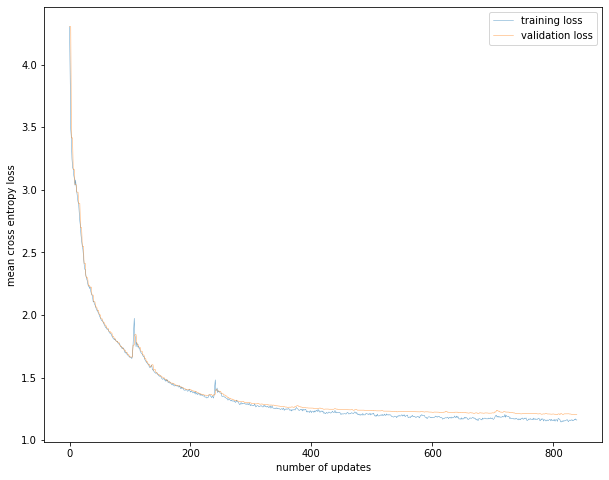

<Figure size 432x288 with 0 Axes>

In [9]:
# best val loss

input_size = 1
embedding_size_input = 128
hidden_sizes = [114, 204, 182]

embedding_size_output = 256
linear_sizes = [128]
output_size = dataset.vocab_len()

model = HMLSTMNetwork(input_size, embedding_size_input, hidden_sizes, embedding_size_output, linear_sizes, output_size,
                      layer_norm=True)
trainer = Trainer(model, None, None, None, device=device)
trainer.load_state(path=path_states + "20200308_231327/" + "complete.pt")

trainer.plot_loss()

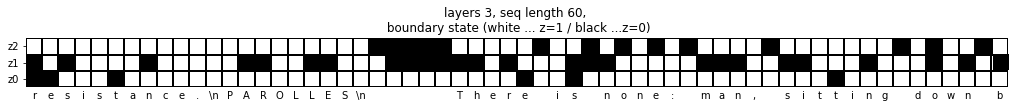

In [10]:
z, text = get_z(x, model, dataset, device)
plot_z(z, list(text))

In [11]:
# this takes some time
results, metrics = evaluate_z(model, dataset, metrics, batch_size=40000, device=device, build_metrics=False)
results = { key: values.cpu().tolist() for key, values in results.items()}

data = pd.DataFrame(results)
data.index = ["layer_" + str(l) for l in range(len(data))]
data.head()

,word_end_f1_score,word_end_accuracy,word_end_cross_entropy,word_start_f1_score,word_start_accuracy,word_start_cross_entropy,blank_after_word_f1_score,blank_after_word_accuracy,blank_after_word_cross_entropy,blank_f1_score,blank_accuracy,blank_cross_entropy,nonblank_f1_score,nonblank_accuracy,nonblank_cross_entropy,random_f1_score,random_accuracy,random_cross_entropy
layer_0,0.341895,0.437055,0.251533,0.277958,0.160130,0.091498,0.000664,0.000293,1.365690,0.000796,0.000302,2.795286,0.849676,0.687028,0.804503,0.578951,0.343764,1.798603
layer_1,0.409628,0.623231,0.430225,0.085733,0.039006,1.486000,0.110760,0.054872,0.737351,0.193027,0.090525,1.756587,0.757456,0.379590,4.343995,0.484762,0.235219,3.048282
layer_2,0.260545,0.207724,0.328076,0.274459,0.157351,0.123457,0.203663,0.112669,0.071899,0.377622,0.229622,0.155137,0.847164,0.673736,0.957498,0.643682,0.451631,0.556718


<Figure size 432x288 with 0 Axes>

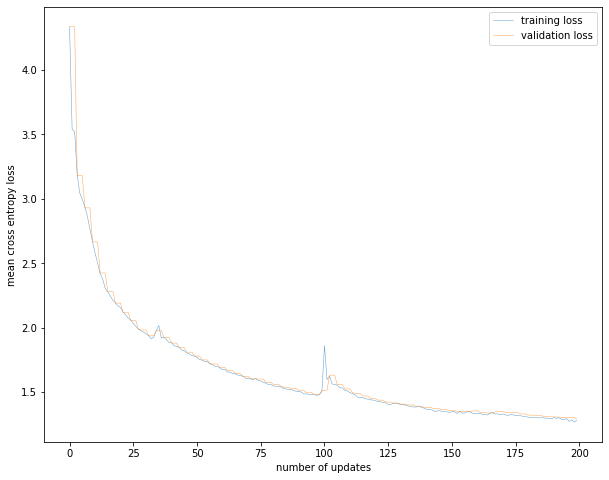

<Figure size 432x288 with 0 Axes>

In [17]:
# 2nd best val loss
input_size = 1
embedding_size_input = 128
hidden_sizes = [256, 128, 64]

embedding_size_output = 256
linear_sizes = [128]
output_size = dataset.vocab_len()

model = HMLSTMNetwork(input_size, embedding_size_input, hidden_sizes, embedding_size_output, linear_sizes, output_size,
                      layer_norm=True)
trainer = Trainer(model, None, None, None, device=device)
trainer.load_state(path=path_states + "20200308_213204/" + "checkpoint.pt")

trainer.plot_loss()

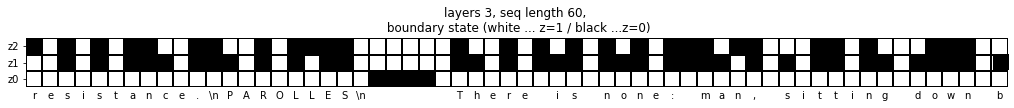

In [18]:
z, text = get_z(x, model, dataset, device)
plot_z(z, list(text))

In [19]:
# this takes some time
results, metrics = evaluate_z(model, dataset, metrics, batch_size=40000, device=device, build_metrics=False)
results = { key: values.cpu().tolist() for key, values in results.items()}

data = pd.DataFrame(results)
data.index = ["layer_" + str(l) for l in range(len(data))]
data.head()


,word_end_f1_score,word_end_accuracy,word_end_cross_entropy,word_start_f1_score,word_start_accuracy,word_start_cross_entropy,blank_after_word_f1_score,blank_after_word_accuracy,blank_after_word_cross_entropy,blank_f1_score,blank_accuracy,blank_cross_entropy,nonblank_f1_score,nonblank_accuracy,nonblank_cross_entropy,random_f1_score,random_accuracy,random_cross_entropy
layer_0,0.212748,0.410294,1.017694,0.167157,0.083487,0.973881,0.166538,0.088027,0.355633,0.353526,0.206957,0.416109,0.754734,0.374037,4.407917,0.537362,0.290388,2.413124
layer_1,0.227303,0.529731,1.138739,0.025567,0.010914,1.809418,0.145586,0.075065,0.504875,0.337433,0.192739,0.579818,0.670901,0.247793,5.861353,0.468274,0.220173,3.221512
layer_2,0.299610,0.229767,0.038346,0.287009,0.167443,0.007271,0.212097,0.118591,0.003721,0.325131,0.182327,0.699639,0.860429,0.749321,0.087309,0.650748,0.465829,0.393266


<Figure size 432x288 with 0 Axes>

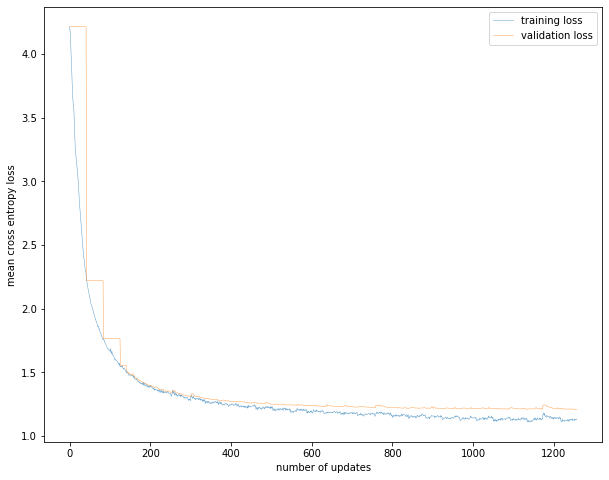

<Figure size 432x288 with 0 Axes>

In [6]:
input_size = 1
embedding_size_input = 32
hidden_sizes = [256, 256, 256]

embedding_size_output = 128
linear_sizes = []
output_size = dataset.vocab_len()

model = HMLSTMNetwork(input_size, embedding_size_input, hidden_sizes, embedding_size_output, linear_sizes, output_size,
                      layer_norm=True)
trainer = Trainer(model, None, None, None, device=device)
trainer.load_state(path=path_states + "20200309_174119/" + "checkpoint.pt")

trainer.plot_loss()

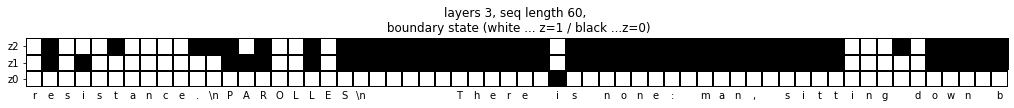

In [7]:
z, text = get_z(x, model, dataset, device)
plot_z(z, list(text))

In [9]:

# this takes some time
results, metrics = evaluate_z(model, dataset, metrics, batch_size=1000, device=device, build_metrics=False)
results = { key: values.cpu().tolist() for key, values in results.items()}

data = pd.DataFrame(results)
data.index = ["layer_" + str(l) for l in range(len(data))]
data.head()




,word_end_f1_score,word_end_accuracy,word_end_cross_entropy,word_start_f1_score,word_start_accuracy,word_start_cross_entropy,blank_after_word_f1_score,blank_after_word_accuracy,blank_after_word_cross_entropy,blank_f1_score,blank_accuracy,blank_cross_entropy,nonblank_f1_score,nonblank_accuracy,nonblank_cross_entropy,random_f1_score,random_accuracy,random_cross_entropy
layer_0,0.267679,0.677286,1.256718,0.058115,0.025666,1.640269,0.001353,0.000597,1.360320,0.001736,0.000658,2.790870,0.691025,0.271885,5.584366,0.352694,0.136258,4.186920
layer_1,0.314568,0.665593,1.052243,0.073979,0.033233,1.553147,0.058024,0.027141,1.054716,0.074297,0.030379,2.448701,0.704164,0.289379,5.382963,0.390033,0.159916,3.914542
layer_2,0.279764,0.242547,0.241985,0.262203,0.147821,0.233845,0.193132,0.105484,0.152713,0.367048,0.219479,0.271559,0.845293,0.664070,1.069143,0.638511,0.441658,0.670833


<Figure size 432x288 with 0 Axes>

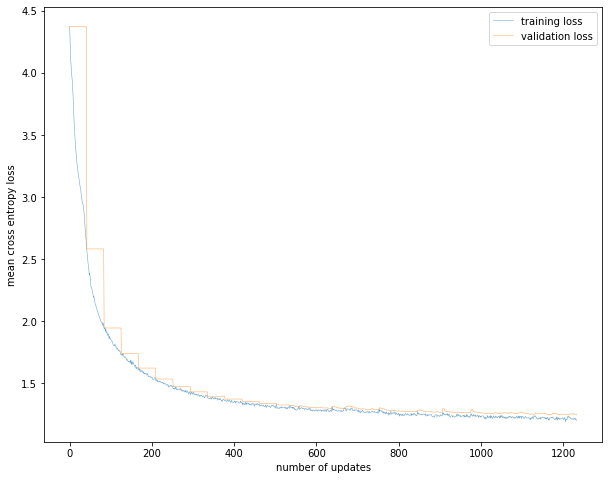

<Figure size 432x288 with 0 Axes>

In [10]:
input_size = 1
embedding_size_input = 32
hidden_sizes = [160, 128, 96]

embedding_size_output = 128
linear_sizes = [64]
output_size = dataset.vocab_len()

model = HMLSTMNetwork(input_size, embedding_size_input, hidden_sizes, embedding_size_output, linear_sizes, output_size,
                      layer_norm=True)

trainer = Trainer(model, None, None, None, device=device)
trainer.load_state(path=path_states + "20200309_210936/" + "checkpoint.pt")

trainer.plot_loss()

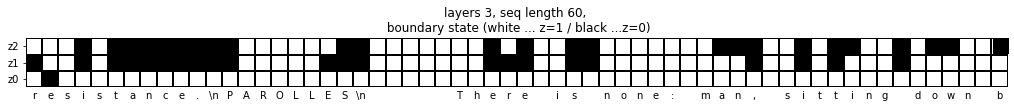

In [11]:
z, text = get_z(x, model, dataset, device)
plot_z(z, list(text))

In [12]:
# this takes some time
results, metrics = evaluate_z(model, dataset, metrics, batch_size=1000, device=device, build_metrics=False)
results = { key: values.cpu().tolist() for key, values in results.items()}

data = pd.DataFrame(results)
data.index = ["layer_" + str(l) for l in range(len(data))]
data.head()


,word_end_f1_score,word_end_accuracy,word_end_cross_entropy,word_start_f1_score,word_start_accuracy,word_start_cross_entropy,blank_after_word_f1_score,blank_after_word_accuracy,blank_after_word_cross_entropy,blank_f1_score,blank_accuracy,blank_cross_entropy,nonblank_f1_score,nonblank_accuracy,nonblank_cross_entropy,random_f1_score,random_accuracy,random_cross_entropy
layer_0,0.219309,0.411586,0.984097,0.236908,0.129142,0.448933,0.177525,0.095117,0.272090,0.356702,0.209863,0.382297,0.755568,0.375734,4.388742,0.539294,0.292706,2.385720
layer_1,0.245051,0.304650,0.636345,0.278046,0.160195,0.091403,0.186771,0.101211,0.201919,0.367177,0.219602,0.270152,0.814412,0.533339,2.574244,0.600862,0.376416,1.421968
layer_2,0.286627,0.178675,0.035992,0.283080,0.164239,0.044818,0.211684,0.118337,0.004724,0.390543,0.242532,0.006147,0.859040,0.740673,0.187220,0.662825,0.491534,0.096615


<Figure size 432x288 with 0 Axes>

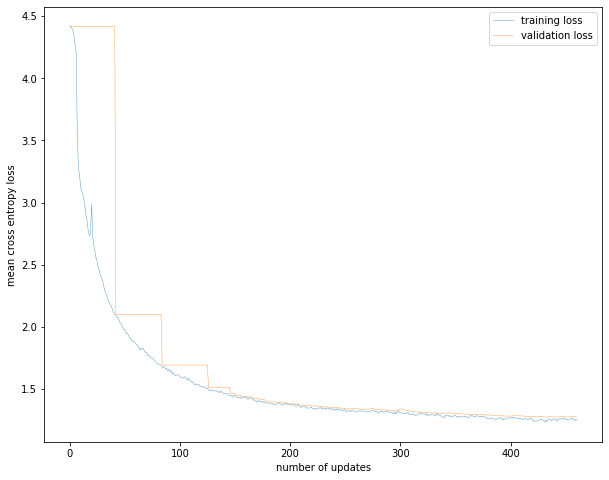

<Figure size 432x288 with 0 Axes>

In [18]:
input_size = 1
embedding_size_input = 32
hidden_sizes = [160, 120, 100, 80, 60, 40]

embedding_size_output = 128
linear_sizes = []
output_size = dataset.vocab_len()

model = HMLSTMNetwork(input_size, embedding_size_input, hidden_sizes, embedding_size_output, linear_sizes, output_size,
                      layer_norm=True)
trainer = Trainer(model, None, None, None, device=device)
trainer.load_state(path=path_states + "20200309_222751/" + "checkpoint.pt")

trainer.plot_loss()

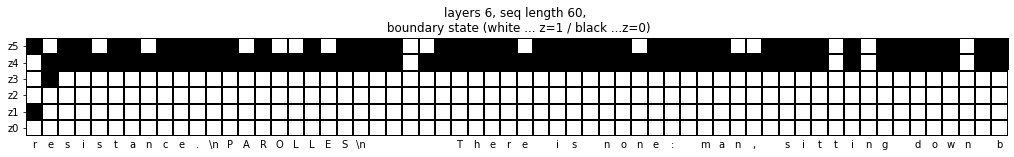

In [19]:
z, text = get_z(x, model, dataset, device)
plot_z(z, list(text))

In [20]:
# this takes some time
results, metrics = evaluate_z(model, dataset, metrics, batch_size=1000, device=device, build_metrics=False)
results = { key: values.cpu().tolist() for key, values in results.items()}

data = pd.DataFrame(results)
data.index = ["layer_" + str(l) for l in range(len(data))]
data.head(n=6)



,word_end_f1_score,word_end_accuracy,word_end_cross_entropy,word_start_f1_score,word_start_accuracy,word_start_cross_entropy,blank_after_word_f1_score,blank_after_word_accuracy,blank_after_word_cross_entropy,blank_f1_score,blank_accuracy,blank_cross_entropy,nonblank_f1_score,nonblank_accuracy,nonblank_cross_entropy,random_f1_score,random_accuracy,random_cross_entropy
layer_0,0.289033,0.733708,1.312585,0.006389,0.002675,1.904969,0.027315,0.012374,1.224743e+00,0.100464,0.042275,2.311751e+00,0.574514,0.164142,6.824797,0.292147,0.103211,4.567390
layer_1,0.136911,0.755929,1.712870,0.018611,0.007888,1.844961,0.035270,0.016109,1.181757e+00,0.094528,0.039516,2.343530e+00,0.381989,0.075145,7.849414,0.186374,0.057287,5.096108
layer_2,0.286560,0.211964,0.113605,0.276549,0.159001,0.105133,0.203175,0.112366,7.347096e-02,0.371717,0.223923,2.203894e-01,0.854278,0.712510,0.511456,0.651823,0.468111,0.366280
layer_3,0.287879,0.168244,0.000044,0.287856,0.168131,0.000011,0.212258,0.118744,3.309657e-05,0.391062,0.243061,5.294624e-05,0.861633,0.756820,0.001326,0.666572,0.499866,0.000677
layer_4,0.288636,0.177961,0.015592,0.285700,0.166368,0.020303,0.209484,0.116781,2.263227e-02,0.387099,0.239042,4.631956e-02,0.860297,0.748420,0.098024,0.663785,0.493650,0.072248
layer_5,0.286681,0.168911,0.012885,0.287159,0.167560,0.006586,0.212262,0.118747,3.474168e-07,0.391066,0.243065,3.474168e-07,0.861174,0.753917,0.034742,0.665920,0.498402,0.017534


<Figure size 432x288 with 0 Axes>

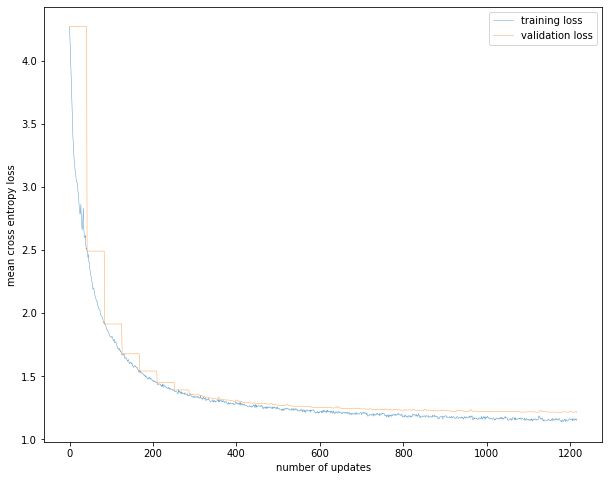

<Figure size 432x288 with 0 Axes>

In [21]:
input_size = 1
embedding_size_input = 32
hidden_sizes = [256, 128, 128]

embedding_size_output = 256
linear_sizes = [128]
output_size = dataset.vocab_len()

model = HMLSTMNetwork(input_size, embedding_size_input, hidden_sizes, embedding_size_output, linear_sizes, output_size,
                      layer_norm=True)
trainer = Trainer(model, None, None, None, device=device)
trainer.load_state(path=path_states + "20200310_130451/" + "checkpoint.pt")

trainer.plot_loss()

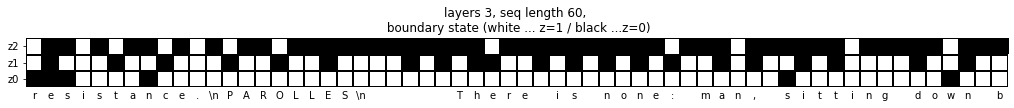

In [23]:
z, text = get_z(x, model, dataset, device)
plot_z(z, list(text))

In [24]:
# this takes some time
results, metrics = evaluate_z(model, dataset, metrics, batch_size=40000, device=device, build_metrics=False)
results = { key: values.cpu().tolist() for key, values in results.items()}

data = pd.DataFrame(results)
data.index = ["layer_" + str(l) for l in range(len(data))]
data.head()




,word_end_f1_score,word_end_accuracy,word_end_cross_entropy,word_start_f1_score,word_start_accuracy,word_start_cross_entropy,blank_after_word_f1_score,blank_after_word_accuracy,blank_after_word_cross_entropy,blank_f1_score,blank_accuracy,blank_cross_entropy,nonblank_f1_score,nonblank_accuracy,nonblank_cross_entropy,random_f1_score,random_accuracy,random_cross_entropy
layer_0,0.263986,0.738137,1.394458,0.009646,0.004052,1.888451,0.032198,0.014656,1.200381,0.037996,0.014948,2.626729,0.586999,0.172761,6.725213,0.272922,0.093838,4.676475
layer_1,0.274264,0.499881,0.847096,0.148914,0.072781,1.097144,0.142224,0.073045,0.528131,0.253191,0.128306,1.321611,0.763657,0.392739,4.192617,0.510338,0.260542,2.757200
layer_2,0.279469,0.242718,0.244227,0.263999,0.149203,0.217270,0.194395,0.106305,0.145173,0.363738,0.216353,0.307907,0.845775,0.666578,1.039913,0.638447,0.441437,0.674556
